# Assignment 1: Labour supply and children
Anton Steinø

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from DynLaborFertModel import DynLaborFertModelClass

## Q1: Beta_1

I inititalize the model, using the parameter settings from the notebook for lecture 5. In lecture five, we visualised the *absolute* labour supply reduction when having a child, but Kleven et al. find a *relative* difference of 10 pct. I take this into account when estimating the true beta_1, which I use for the remainder of the assignment.

In [2]:
# load local model file and initialize model class

model = DynLaborFertModelClass()

par = model.par
sol = model.sol
sim = model.sim

In [3]:
#########################################
## SETUP FOR CHILD PENALTY CALIBRATION ##

# setup for births
periods = np.tile([t for t in range(par.simT)],(par.simN,1))
birth = np.zeros(sim.n.shape,dtype=np.int_)

# define objective function
def obj_func(theta,theta_names,mom_data,model,do_print=False):
    
    theta = np.array((theta,0))
    
    # printing
    if do_print: 
        print_str = ''
        for i,name in enumerate(theta_names):
            print_str += f'{name} = {theta[i]:2.5f} '
        print(print_str)
            
    # calculate moments from simulation
    mom_sim = simulate_moments(theta,theta_names,model,do_print=False)
    
    # equal weighting
    obj = np.sum((mom_data - mom_sim)**2)
    
    # return objective and moments for plotting
    return obj

# define simulation function
def simulate_moments(theta,theta_names,model,do_print=False):
    
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    %time model.solve()
    model.simulate()
    
    # return moments from simulated data
    return moment_func(model)

# define simulated penalty function
def moment_func(model):
    
    # unpack
    sim = model.sim
    
    # time since birth
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0
    time_of_birth = np.max(periods * birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never as a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # calculate average outcome across time since birth
    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # relative to period before birth
    event_hours_rel = (event_hours - event_hours[event_grid==-1])/event_hours[event_grid==-1]
    
    print(f'Penalty is: {event_hours_rel[-min_time]:.5} \n')
    
    return event_hours_rel[-min_time] # penalty at birth

In [4]:
# set minimization inputs

theta_names = ('beta_1',) # parameter to be calibrated
mom_data = -0.100 # target hours penalty from Kleven et al. is 10 pct.
init = np.array(0.052992) # not so random guess for convenience

# call numerical optimizer (takes ~70 minutes)

obj = lambda x: obj_func(x[0],theta_names,mom_data,model,do_print=True)
res = minimize(obj,init,method='nelder-mead') 

beta_1 = 0.05299 
CPU times: user 5min 25s, sys: 4.1 s, total: 5min 29s
Wall time: 6min 1s
Penalty is: -0.099969 

beta_1 = 0.05564 
CPU times: user 4min 59s, sys: 3.13 s, total: 5min 2s
Wall time: 5min 11s
Penalty is: -0.10377 

beta_1 = 0.05034 
CPU times: user 5min 25s, sys: 4.02 s, total: 5min 29s
Wall time: 5min 44s
Penalty is: -0.096049 

beta_1 = 0.05432 
CPU times: user 5min 3s, sys: 3.17 s, total: 5min 6s
Wall time: 5min 15s
Penalty is: -0.10192 

beta_1 = 0.05167 
CPU times: user 4min 52s, sys: 2.82 s, total: 4min 55s
Wall time: 5min 3s
Penalty is: -0.098018 

beta_1 = 0.05365 
CPU times: user 4min 18s, sys: 406 ms, total: 4min 19s
Wall time: 4min 19s
Penalty is: -0.10089 

beta_1 = 0.05233 
CPU times: user 4min 19s, sys: 422 ms, total: 4min 19s
Wall time: 4min 20s
Penalty is: -0.099002 

beta_1 = 0.05332 
CPU times: user 4min 19s, sys: 423 ms, total: 4min 19s
Wall time: 4min 20s
Penalty is: -0.10046 

beta_1 = 0.05266 
CPU times: user 4min 16s, sys: 269 ms, total: 4min 16s
W

In [5]:
print(f'The correct beta_1 is given by: {res.x[0]} \n')
print(res)

The correct beta_1 is given by: 0.052992 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9.307953397293218e-10
             x: [ 5.299e-02]
           nit: 6
          nfev: 12
 final_simplex: (array([[ 5.299e-02],
                       [ 5.307e-02]]), array([ 9.308e-10,  3.099e-09]))


In [42]:
# initialize working model
model = DynLaborFertModelClass(par={'beta_1':res.x[0]}) # baseline model

par = model.par
sol = model.sol
sim = model.sim

0.052992


In [43]:
# solve and simulate
%time model.solve()
model.simulate()


CPU times: user 5min 4s, sys: 3.24 s, total: 5min 7s
Wall time: 5min 20s


Setting beta_1 to 0.052992 gives an estimated penalty of -10.00 %


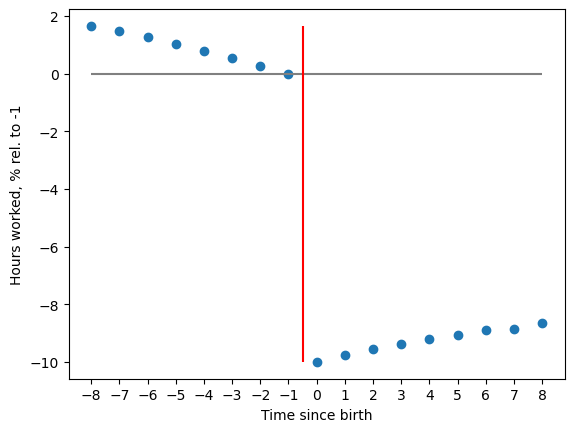

In [44]:
# calculate child penalty

event_hours_rel = model.ChildPenalty()# hours penalty at birth

print(f'Setting beta_1 to {par.beta_1:.5} gives an estimated penalty of {event_hours_rel[-par.min_time]*100:2.2f} %')

# plot the penalty ## FIGURE 1 ##

fig, ax = plt.subplots()
ax.scatter(par.event_grid,event_hours_rel*100)
ax.hlines(y=0,xmin=par.event_grid[0],xmax=par.event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel*100),ymax=np.nanmax(event_hours_rel*100),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Hours worked, % rel. to -1',xticks=par.event_grid);

fig.savefig('figs/fig1.png')

## Q2: Marshall elasticity

I assume that the question asks to find the relative hours response to a 1pp increase in the tax rate, as this approximately gives a 1% reduction in after tax wages (for any given level of wages). I thus calculate the relative change in hours from changing the tax rate from 10% to 11%.

If we were to be exact, we should instead have looked at changing the tax rate to 10.9%

In [45]:
# save simulation results

c_bl = sim.c.copy()
h_bl = sim.h.copy()
a_bl = sim.a.copy()
k_bl = sim.k.copy()
n_bl = sim.n.copy()

In [46]:
# change tax rate, solve and simulate

par.tau = 0.11

model.solve()
model.simulate()

# save simulation results

c_q2 = sim.c.copy()
h_q2 = sim.h.copy()
a_q2 = sim.a.copy()
k_q2 = sim.k.copy()
n_q2 = sim.n.copy()

In [47]:
# calculate individual Marshall elasticity
e_M_i = -(h_q2-h_bl)/h_bl*100

# unconditional elasticity
e_M = -(np.mean(h_q2)-np.mean(h_bl))/np.mean(h_bl)*100

# conditional on age
e_M_t = np.zeros((par.simT))

for t in range(par.simT):
    e_M_t[t] = -(np.mean(h_q2[:,t])-np.mean(h_bl[:,t]))/np.mean(h_bl[:,t])*100

#conditional on child
e_M_n0 = -(np.mean(h_q2[sim.n==0])-np.mean(h_bl[sim.n==0]))/np.mean(h_bl[sim.n==0])*100
e_M_n1 = -(np.mean(h_q2[sim.n==1])-np.mean(h_bl[sim.n==1]))/np.mean(h_bl[sim.n==1])*100

# conditional on age and child
e_M_n0_t = np.zeros((par.simT))
e_M_n1_t = np.zeros((par.simT))

for t in range(par.simT):
    e_M_n0_t[t] = -(np.mean(h_q2[:,t][sim.n[:,t]==0])-np.mean(h_bl[:,t][sim.n[:,t]==0]))/np.mean(h_bl[:,t][sim.n[:,t]==0])*100
    e_M_n1_t[t] = -(np.mean(h_q2[:,t][sim.n[:,t]==1])-np.mean(h_bl[:,t][sim.n[:,t]==1]))/np.mean(h_bl[:,t][sim.n[:,t]==1])*100
    

/Users/Anton/opt/anaconda3/envs/environ/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Anton/opt/anaconda3/envs/environ/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
#print results

print(f'Aggregate Marshall elasticity is {e_M:.5}')
print(f'Marshall elasticity conditional on age is {e_M_t.round(3)}')
print(f'The average difference in elasticity between mothers (e = {e_M_n1:.3}) and non-mothers (e = {e_M_n0:.3}) is {e_M_n1-e_M_n0:.5}')

Aggregate Marshall elasticity is -0.22825
Marshall elasticity conditional on age is [-0.231 -0.23  -0.202 -0.21  -0.24  -0.226 -0.224 -0.291 -0.106 -0.325]
The average difference in elasticity between mothers (e = -0.238) and non-mothers (e = -0.223) is -0.015129


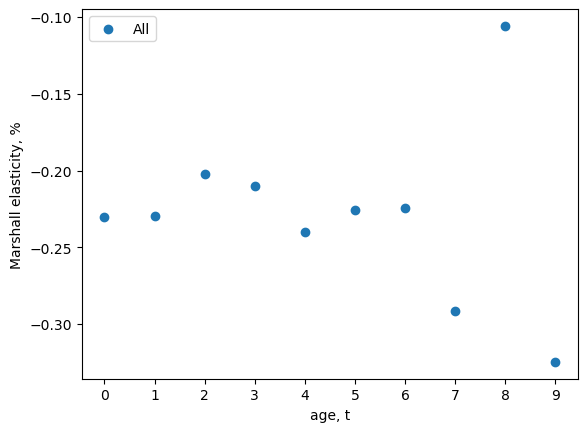

In [49]:
# plot age-contingent elasticities  ## FIGURE 2 ##

fig, ax = plt.subplots()
ax.scatter(np.arange(par.T),e_M_t,label='All')
ax.set(xlabel='age, t',ylabel=f'Marshall elasticity, %',xticks=np.arange(par.T))
ax.legend();

fig.savefig('figs/fig2.png')

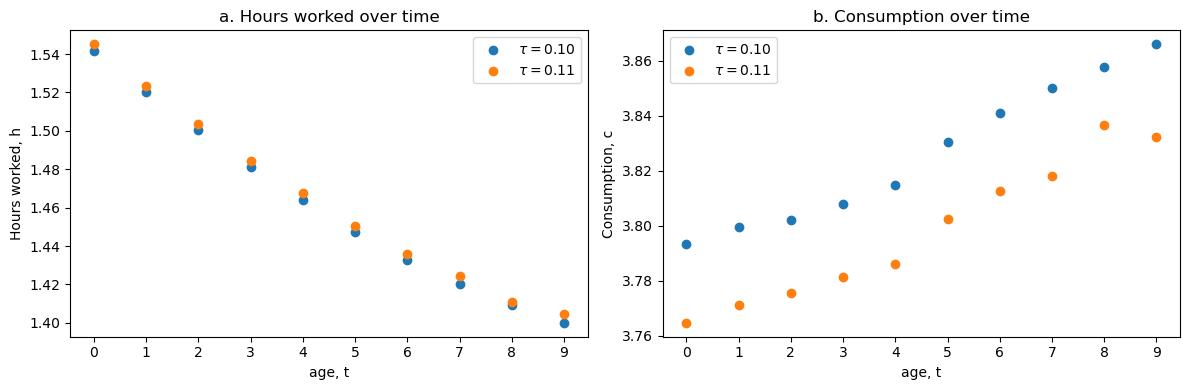

In [50]:
# plot behaviour  ## FIGURE 3 a. and b. ##

h_bl_t = np.zeros((par.T))
h_q2_t = np.zeros((par.T))
c_bl_t = np.zeros((par.T))
c_q2_t = np.zeros((par.T))

for t in range(par.T):
    h_bl_t[t] = np.mean(h_bl[:,t])
    h_q2_t[t] = np.mean(h_q2[:,t])
    c_bl_t[t] = np.mean(c_bl[:,t])
    c_q2_t[t] = np.mean(c_q2[:,t])

# plot age-contingent elasticities
fig = plt.figure(figsize=(12,4),dpi=100)

# i. hours
ax = fig.add_subplot(1,2,1)
ax.set_title(f'a. Hours worked over time')
ax.scatter(np.arange(par.T),h_bl_t,label=f'$\\tau = 0.10$')
ax.scatter(np.arange(par.T),h_q2_t,label=f'$\\tau = 0.11$')
ax.set(xlabel='age, t',ylabel=f'Hours worked, h',xticks=np.arange(par.T))
ax.legend()

# ii. consumption
ax = fig.add_subplot(1,2,2)
ax.set_title(f'b. Consumption over time')
ax.scatter(np.arange(par.T),c_bl_t,label=f'$\\tau = 0.10$')
ax.scatter(np.arange(par.T),c_q2_t,label=f'$\\tau = 0.11$')
ax.set(xlabel='age, t',ylabel=f'Consumption, c',xticks=np.arange(par.T))
ax.legend()

fig.tight_layout()

fig.savefig('figs/fig3a.png')



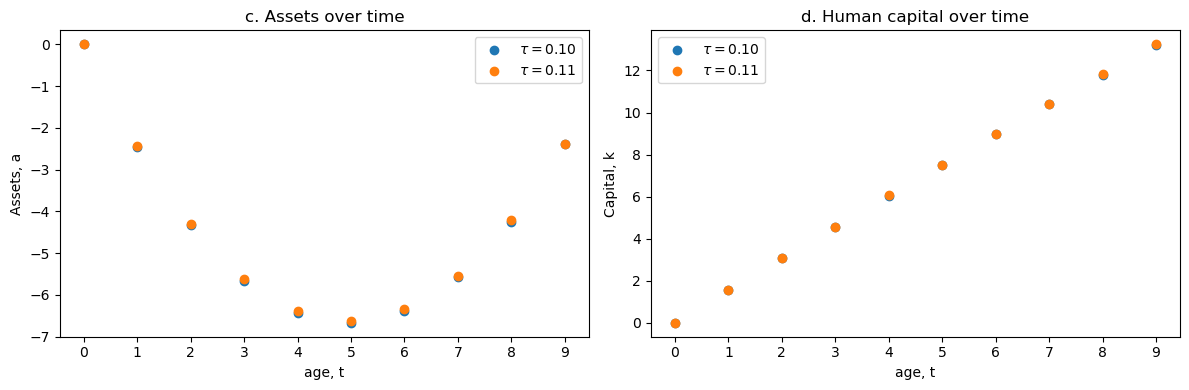

In [51]:
# plot behaviour  ## FIGURE 3 c. and d. ##

a_bl_t = np.zeros((par.T))
a_q2_t = np.zeros((par.T))
k_bl_t = np.zeros((par.T))
k_q2_t = np.zeros((par.T))

for t in range(par.T):
    a_bl_t[t] = np.mean(a_bl[:,t])
    a_q2_t[t] = np.mean(a_q2[:,t])
    k_bl_t[t] = np.mean(k_bl[:,t])
    k_q2_t[t] = np.mean(k_q2[:,t])

# plot age-contingent elasticities
fig = plt.figure(figsize=(12,4),dpi=100)

# i. assets
ax = fig.add_subplot(1,2,1)
ax.set_title(f'c. Assets over time')
ax.scatter(np.arange(par.T),a_bl_t,label=f'$\\tau = 0.10$')
ax.scatter(np.arange(par.T),a_q2_t,label=f'$\\tau = 0.11$')
ax.set(xlabel='age, t',ylabel=f'Assets, a',xticks=np.arange(par.T))
ax.legend()

# ii. Human capital
ax = fig.add_subplot(1,2,2)
ax.set_title(f'd. Human capital over time')
ax.scatter(np.arange(par.T),k_bl_t,label=f'$\\tau = 0.10$')
ax.scatter(np.arange(par.T),k_q2_t,label=f'$\\tau = 0.11$')
ax.set(xlabel='age, t',ylabel=f'Capital, k',xticks=np.arange(par.T))
ax.legend()

fig.tight_layout()

fig.savefig('figs/fig3c.png')

In [52]:
# DEBUGGING: Error in baseline

error_bl = np.zeros((par.simN,par.simT))

for t in range(par.T-1):
    error_bl[:,t] = c_bl[:,t]+a_bl[:,t+1]/(1+par.r)-(a_bl[:,t] + 0.9*par.w_vec[t]*(1+par.alpha*k_bl[:,t])*h_bl[:,t])

error_bl[:,par.T-1] = c_bl[:,par.T-1]-(a_bl[:,par.T-1] + 0.9*par.w_vec[par.T-1]*(1+par.alpha*k_bl[:,par.T-1])*h_bl[:,par.T-1])

for t in (7,8,9):
    print(np.mean(error_bl[:,t][n_bl[:,t] == 0]))
    print(np.mean(error_bl[:,t][n_bl[:,t] == 1]))
    print(f'\n')

0.0
-4.0881705251268924e-17


0.0
0.0


-0.0031252154728553805
-0.0019298517937627003




In [17]:
# DEBUGGING: Error in que 2

error_q2 = np.zeros((par.simN,par.simT))

for t in range(par.T-1):
    error_q2[:,t] = c_q2[:,t]+a_q2[:,t+1]/(1+par.r)-(a_q2[:,t] + 0.89*par.w_vec[t]*(1+par.alpha*k_q2[:,t])*h_q2[:,t])

error_q2[:,par.T-1] = c_q2[:,par.T-1]-(a_q2[:,par.T-1] + 0.89*par.w_vec[par.T-1]*(1+par.alpha*k_q2[:,par.T-1])*h_q2[:,par.T-1])

for t in (7,8,9):
    print(np.mean(error_q2[:,t][n_q2[:,t] == 0]))
    print(np.mean(error_q2[:,t][n_q2[:,t] == 1]))
    print(f'\n')

0.0
6.196000650348242e-17


0.0
0.0


-0.003108717531596028
-0.001928550651644893




## Q3: Introducing a spouse

I have set up the code, such that any par.p_spouse > 0.0 will trigger evaluation of spouse-dependent solutions. This doubles evaluation time for the model. For this question, everyone has a spouse each period, so p_spouse = 1.0.


In [18]:
model_s = DynLaborFertModelClass(par={'beta_1':res.x[0],'p_spouse':1.0}) # spouse

par = model_s.par
sol = model_s.sol
sim = model_s.sim

In [19]:
model_s.solve()
model_s.simulate()

In [20]:
# save simulation results

c_q3 = sim.c.copy()
h_q3 = sim.h.copy()
a_q3 = sim.a.copy()
k_q3 = sim.k.copy()
n_q3 = sim.n.copy()
s_q3 = sim.s.copy()

In [21]:
# A: Child penalty

event_hours_rel_q3 = model_s.ChildPenalty()# hours penalty at birth

print(f'Wth a spouse present w.p. 1, the hours penalty becomes {event_hours_rel_q3[-par.min_time]*100:2.2f} %')

Wth a spouse present w.p. 1, the hours penalty becomes -10.08 %


In [22]:
# B: Marshall elasticity

# change tax rate, solve and simulate

par.tau = 0.11

model_s.solve()
model_s.simulate()

# save simulation results

c_q3_alt = sim.c.copy()
h_q3_alt = sim.h.copy()
a_q3_alt = sim.a.copy()
k_q3_alt = sim.k.copy()
n_q3_alt = sim.n.copy()
s_q3_alt = sim.s.copy()

In [23]:
# calculate individual Marshall elasticity
e_M_i_q3 = -(h_q3_alt-h_q3)/h_q3*100

# unconditional elasticity
e_M_q3 = -(np.mean(h_q3_alt)-np.mean(h_q3))/np.mean(h_q3)*100

# conditional on age
e_M_t_q3 = np.zeros((par.simT))

for t in range(par.simT):
    e_M_t_q3[t] = -(np.mean(h_q3_alt[:,t])-np.mean(h_q3[:,t]))/np.mean(h_q3[:,t])*100

#conditional on child
e_M_n0_q3 = -(np.mean(h_q3_alt[sim.n==0])-np.mean(h_q3[sim.n==0]))/np.mean(h_q3[sim.n==0])*100
e_M_n1_q3 = -(np.mean(h_q3_alt[sim.n==1])-np.mean(h_q3[sim.n==1]))/np.mean(h_q3[sim.n==1])*100

print(f'The aggregate Marshall elasticity changes from {e_M:.4} when no spouse to {e_M_q3:.4} when a spouse is certain')

The aggregate Marshall elasticity changes from nan when no spouse to -0.2181 when a spouse is certain


In [24]:
# DEBUGGING: Error in que 3

error_q3 = np.zeros((par.simN,par.simT))

for t in range(par.T-1):
    error_q3[:,t] = c_q3[:,t]+a_q3[:,t+1]/(1+par.r)-(a_q3[:,t] + 0.9*par.w_vec[t]*(1+par.alpha*k_q3[:,t])*h_q3[:,t]+par.y_vec[t]*s_q3[:,t])

error_q3[:,par.T-1] = c_q3[:,par.T-1]-(a_q3[:,par.T-1] + 0.9*par.w_vec[par.T-1]*(1+par.alpha*k_q3[:,par.T-1])*h_q3[:,par.T-1]+ par.y_vec[par.T-1]*s_q3[:,par.T-1])


for t in range(par.T):
    print(np.mean(error_q3[:,t][n_q3[:,t] == 0]))
    print(np.mean(error_q3[:,t][n_q3[:,t] == 1]))
    print(f'\n')

2.220446049250313e-16
nan


3.3306690738754696e-16
-3.3306690738754696e-16


-4.440892098500626e-16
0.0


0.0
1.4369027933221154e-16


0.0
-2.0470740326807398e-16


4.440892098500626e-16
-1.888729778145765e-16


2.220446049250313e-16
2.365739735923161e-16


-8.326672684688674e-17
-6.011140548640321e-17


-2.220446049250313e-16
-2.220446049250313e-16


-0.0026164638374384097
-0.0020011629122558593




## Q4: Child care cost

Compare baseline (no spouse and no child care cost) to the case with a positive cost of childcare, $\theta = 0.05$.



In [25]:
#model_c = DynLaborFertModelClass(par={'beta_1':0.052992084375,'theta':0.05}) # child care cost
model_c = DynLaborFertModelClass(par={'beta_1':res.x[0],'theta':0.05}) # child care cost

par = model_c.par
sol = model_c.sol
sim = model_c.sim

In [26]:
model_c.solve()
model_c.simulate()

In [27]:
# save simulation results

c_q4 = sim.c.copy()
h_q4 = sim.h.copy()
a_q4 = sim.a.copy()
k_q4 = sim.k.copy()
n_q4 = sim.n.copy()

Wth a child care cost of 0.0 the hours penalty becomes -9.63 %


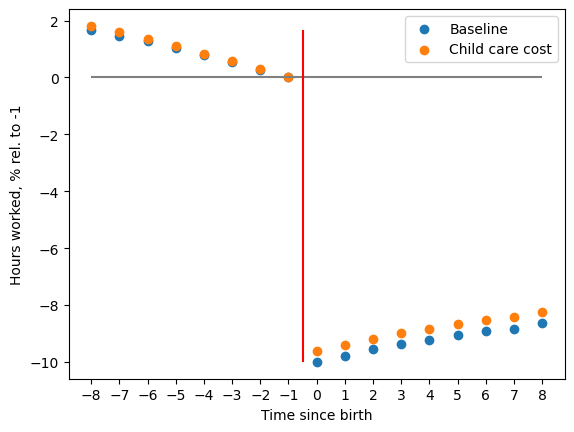

In [53]:
# A: Child penalty

event_hours_rel_q4 = model_c.ChildPenalty() # hours penalty at birth

print(f'Wth a child care cost of {par.theta} the hours penalty becomes {event_hours_rel_q4[-par.min_time]*100:2.2f} %')

# plot the penalty ## FIGURE 5 ##

fig, ax = plt.subplots()
ax.scatter(par.event_grid,event_hours_rel*100,label=f'Baseline')
ax.scatter(par.event_grid,event_hours_rel_q4*100,label=f'Child care cost')
ax.hlines(y=0,xmin=par.event_grid[0],xmax=par.event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel*100),ymax=np.nanmax(event_hours_rel*100),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Hours worked, % rel. to -1',xticks=par.event_grid)
ax.legend();

fig.savefig('figs/fig5.png')

In [29]:
# B: Marshall elasticity

# change tax rate, solve and simulate

par.tau = 0.11

model_c.solve()
model_c.simulate()

# save simulation results

c_q4_alt = sim.c.copy()
h_q4_alt = sim.h.copy()
a_q4_alt = sim.a.copy()
k_q4_alt = sim.k.copy()
n_q4_alt = sim.n.copy()

In [30]:
# calculate individual Marshall elasticity
e_M_i_q4 = -(h_q4_alt-h_q4)/h_q4*100

# unconditional elasticity
e_M_q4 = -(np.mean(h_q4_alt)-np.mean(h_q4))/np.mean(h_q4)*100

# conditional on age
e_M_t_q4 = np.zeros((par.simT))

for t in range(par.simT):
    e_M_t_q4[t] = -(np.mean(h_q4_alt[:,t])-np.mean(h_q4[:,t]))/np.mean(h_q4[:,t])*100

#conditional on child
e_M_n0_q4 = -(np.mean(h_q4_alt[sim.n==0])-np.mean(h_q4[sim.n==0]))/np.mean(h_q4[sim.n==0])*100
e_M_n1_q4 = -(np.mean(h_q4_alt[sim.n==1])-np.mean(h_q4[sim.n==1]))/np.mean(h_q4[sim.n==1])*100

print(f'The aggregate Marshall elasticity changes from {e_M:.4} in the baseline case to {e_M_q4:.4} with child care cost')

The aggregate Marshall elasticity changes from nan in the baseline case to -0.2306 with child care cost


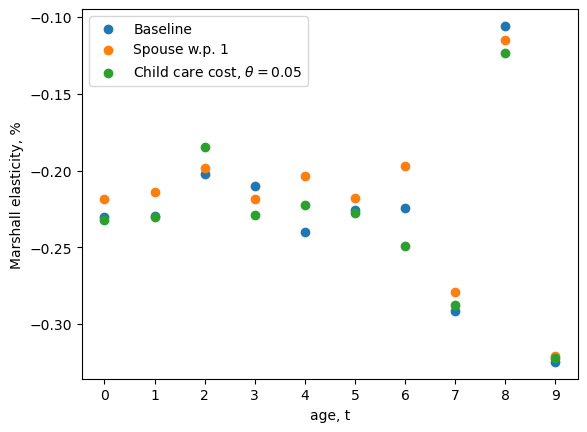

In [54]:
# plot age-contingent elasticities ## FIGURE 4 ## 

fig, ax = plt.subplots()
ax.scatter(np.arange(par.T),e_M_t,label='Baseline')
ax.scatter(np.arange(par.T),e_M_t_q3,label='Spouse w.p. 1')
ax.scatter(np.arange(par.T),e_M_t_q4,label=f'Child care cost, $\\theta = 0.05$')
ax.set(xlabel='age, t',ylabel=f'Marshall elasticity, %',xticks=np.arange(par.T))
ax.legend();

fig.savefig('figs/fig4.png')

In [32]:
# DEBUGGING: Error in que 4

error_q4 = np.zeros((par.simN,par.simT))

for t in range(par.T-1):
    error_q4[:,t] = c_q4[:,t]+a_q4[:,t+1]/(1+par.r)-(a_q4[:,t] + 0.9*par.w_vec[t]*(1+par.alpha*k_q4[:,t])*h_q4[:,t]-par.theta*n_q4[:,t])

error_q4[:,par.T-1] = c_q4[:,par.T-1]-(a_q4[:,par.T-1] + 0.9*par.w_vec[par.T-1]*(1+par.alpha*k_q4[:,par.T-1])*h_q4[:,par.T-1]-par.theta*n_q4[:,par.T-1])

for t in (7,8,9):
    print(np.mean(error_q4[:,t][n_q4[:,t] == 0]))
    print(np.mean(error_q4[:,t][n_q4[:,t] == 1]))
    print(f'\n')


0.0
3.096937910796489e-16


0.0
2.220446049250313e-16


-0.0031204172800478602
-0.0018940868119880284




## Q6: Spouse w.p. 0.8

In [33]:
model_s80 = DynLaborFertModelClass(par={'beta_1':res.x[0],'p_spouse':0.8}) # spouse

par = model_s80.par
sol = model_s80.sol
sim = model_s80.sim

In [34]:
model_s80.solve()
model_s80.simulate()

In [35]:
# save simulation results

c_q6 = sim.c.copy()
h_q6 = sim.h.copy()
a_q6 = sim.a.copy()
k_q6 = sim.k.copy()
n_q6 = sim.n.copy()
s_q6 = sim.s.copy()

In [36]:
# A: Child penalty

event_hours_rel_q6 = model_s80.ChildPenalty()# hours penalty at birth

print(f'If a spouse is present w.p. 0.8, the hours penalty becomes {event_hours_rel_q6[-par.min_time]*100:2.2f} %')

If a spouse is present w.p. 0.8, the hours penalty becomes -9.71 %


In [37]:
# B: Marshall elasticity

# change tax rate, solve and simulate
par.tau = 0.11

model_s80.solve()
model_s80.simulate()

# save simulation results
c_q6_alt = sim.c.copy()
h_q6_alt = sim.h.copy()
a_q6_alt = sim.a.copy()
k_q6_alt = sim.k.copy()
n_q6_alt = sim.n.copy()
s_q6_alt = sim.s.copy()


In [38]:
# calculate individual Marshall elasticity
e_M_i_q6 = -(h_q6_alt-h_q6)/h_q6*100

# unconditional elasticity
e_M_q6 = -(np.mean(h_q6_alt)-np.mean(h_q6))/np.mean(h_q6)*100

# conditional on age
e_M_t_q6 = np.zeros((par.simT))

for t in range(par.simT):
    e_M_t_q6[t] = -(np.mean(h_q6_alt[:,t])-np.mean(h_q6[:,t]))/np.mean(h_q6[:,t])*100

#conditional on child
e_M_n0_q6 = -(np.mean(h_q6_alt[sim.n==0])-np.mean(h_q6[sim.n==0]))/np.mean(h_q6[sim.n==0])*100
e_M_n1_q6 = -(np.mean(h_q6_alt[sim.n==1])-np.mean(h_q6[sim.n==1]))/np.mean(h_q6[sim.n==1])*100

print(f'The aggregate Marshall elasticity changes from {e_M:.4} in the baseline case to {e_M_q6:.4} when a spouse is present w.p. 0.8')

The aggregate Marshall elasticity changes from nan in the baseline case to -0.2174 when a spouse is present w.p. 0.8


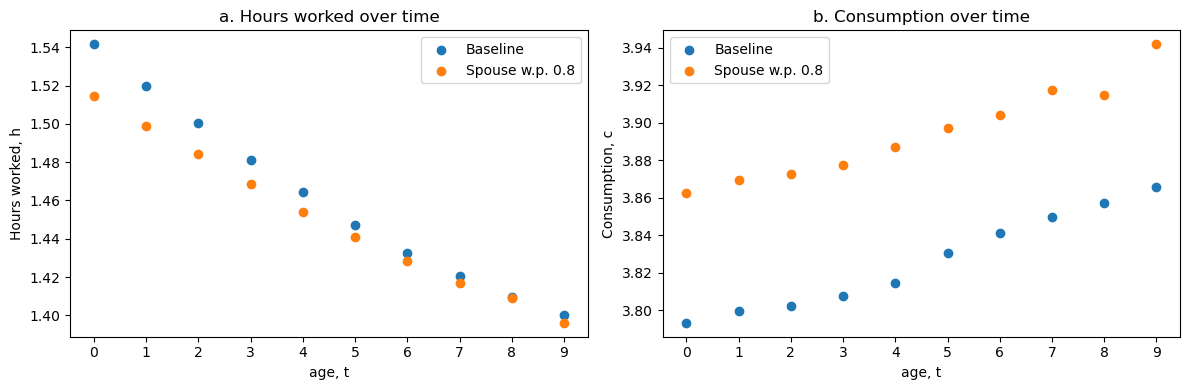

In [55]:
# C: Plot behaviour  ## FIGURE 6 a. and b. ##

h_q6_t = np.zeros((par.T))
c_q6_t = np.zeros((par.T))

for t in range(par.T):
    h_q6_t[t] = np.mean(h_q6[:,t])
    c_q6_t[t] = np.mean(c_q6[:,t])

# plot age-contingent elasticities
fig = plt.figure(figsize=(12,4),dpi=100)

# i. hours
ax = fig.add_subplot(1,2,1)
ax.set_title(f'a. Hours worked over time')
ax.scatter(np.arange(par.T),h_bl_t,label=f'Baseline')
ax.scatter(np.arange(par.T),h_q6_t,label=f'Spouse w.p. 0.8')
ax.set(xlabel='age, t',ylabel=f'Hours worked, h',xticks=np.arange(par.T))
ax.legend()

# ii. consumption
ax = fig.add_subplot(1,2,2)
ax.set_title(f'b. Consumption over time')
ax.scatter(np.arange(par.T),c_bl_t,label=f'Baseline')
ax.scatter(np.arange(par.T),c_q6_t,label=f'Spouse w.p. 0.8')
ax.set(xlabel='age, t',ylabel=f'Consumption, c',xticks=np.arange(par.T))
ax.legend()

fig.tight_layout()

fig.savefig('figs/fig6a.png')

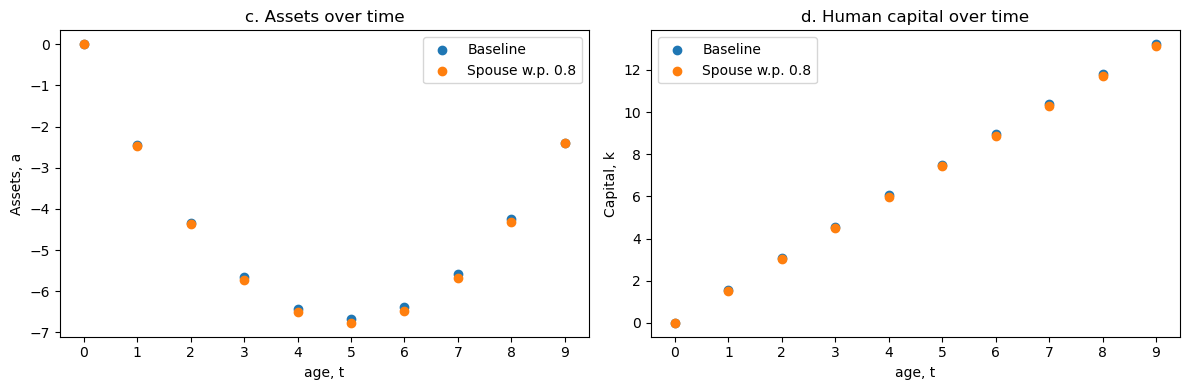

In [56]:
# plot behaviour  ## FIGURE 6 c. and d. ##

a_q6_t = np.zeros((par.T))
k_q6_t = np.zeros((par.T))

for t in range(par.T):
    a_q6_t[t] = np.mean(a_q6[:,t])
    k_q6_t[t] = np.mean(k_q6[:,t])

# plot age-contingent elasticities
fig = plt.figure(figsize=(12,4),dpi=100)

# i. assets
ax = fig.add_subplot(1,2,1)
ax.set_title(f'c. Assets over time')
ax.scatter(np.arange(par.T),a_bl_t,label=f'Baseline')
ax.scatter(np.arange(par.T),a_q6_t,label=f'Spouse w.p. 0.8')
ax.set(xlabel='age, t',ylabel=f'Assets, a',xticks=np.arange(par.T))
ax.legend()

# ii. Human capital
ax = fig.add_subplot(1,2,2)
ax.set_title(f'd. Human capital over time')
ax.scatter(np.arange(par.T),k_bl_t,label=f'Baseline')
ax.scatter(np.arange(par.T),k_q6_t,label=f'Spouse w.p. 0.8')
ax.set(xlabel='age, t',ylabel=f'Capital, k',xticks=np.arange(par.T))
ax.legend()

fig.tight_layout()

fig.savefig('figs/fig6c.png')

In [41]:
# DEBUGGING: Error in que 6

error_q6 = np.zeros((par.simN,par.simT))

for t in range(par.T-1):
    error_q6[:,t] = c_q6[:,t]+a_q6[:,t+1]/(1+par.r)-(a_q6[:,t] + 0.9*par.w_vec[t]*(1+par.alpha*k_q6[:,t])*h_q6[:,t] + par.y_vec[t]*s_q6[:,t])

error_q6[:,par.T-1] = c_q6[:,par.T-1]-(a_q6[:,par.T-1] + 0.9*par.w_vec[par.T-1]*(1+par.alpha*k_q6[:,par.T-1])*h_q6[:,par.T-1] + par.y_vec[par.T-1]*s_q6[:,par.T-1])

for t in range(par.T):
    print(np.mean(error_q6[:,t][s_q6[:,t] == 0]))
    print(np.mean(error_q6[:,t][s_q6[:,t] == 1]))
    print(f'\n')


-2.220446049250313e-16
0.0


-4.440892098500626e-16
8.48213185585236e-18


4.454390250775704e-17
-1.1785572102923416e-16


1.8005999228163828e-16
-3.893080111396917e-18


-1.1821870108824031e-16
-1.1265027706937295e-16


-1.13172581511229e-18
3.227077724227688e-16


6.768321290733501e-18
2.0964065699738395e-16


2.154671855758731e-17
-9.173628448935794e-17


0.0
-2.220446049250313e-16


-0.0024728065751126083
-0.002347870600014134


